# Military Soldier Safety and Weapon Detection using YOLO and Computer Vision

In [26]:

import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import yaml
import sys
from yolov5 import train
import random
import shutil

import warnings
warnings.filterwarnings('ignore')
train_path = 'D:/Final_project/military_object_dataset/train'


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline


### Load Dataset Info

In [2]:
# Function to load image and label paths
def load_dataset_info(path):
    image_paths = []
    label_paths = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                image_paths.append(os.path.join(root, file))
            elif file.endswith('.txt'):
                label_paths.append(os.path.join(root, file))
    return image_paths, label_paths

# Load the dataset
image_paths, label_paths = load_dataset_info(train_path)

print(f"Number of images: {len(image_paths)}")
print(f"Number of label files: {len(label_paths)}")

Number of images: 21978
Number of label files: 21978


# Exploratory Data Analysis (EDA)

### Image Analysis - Size and Resolution

In [3]:

def get_image_dimensions(image_paths):
    heights = []
    widths = []
    for img_path in image_paths[:100]:  
        img = cv2.imread(img_path)
        if img is not None:
            heights.append(img.shape[0])
            widths.append(img.shape[1])
    return heights, widths

heights, widths = get_image_dimensions(image_paths)

# Identify outliers
print(f"Min Height: {min(heights)}, Max Height: {max(heights)}")
print(f"Min Width: {min(widths)}, Max Width: {max(widths)}")

Min Height: 640, Max Height: 640
Min Width: 640, Max Width: 640


### Image Analysis - Aspect Ratio

In [4]:
aspect_ratios = [w / h for w, h in zip(widths, heights)]

print(f"Average Aspect Ratio: {np.mean(aspect_ratios):.2f}")
print(f"Min Aspect Ratio: {min(aspect_ratios):.2f}, Max Aspect Ratio: {max(aspect_ratios):.2f}")

Average Aspect Ratio: 1.00
Min Aspect Ratio: 1.00, Max Aspect Ratio: 1.00


### Image Analysis - Image Quality

In [5]:

def check_image_quality(img_path):
    img = cv2.imread(img_path, 0) 
    if img is None:
        return 'Corrupted'

    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    return 'Blurry' if laplacian_var < 100 else 'Clear'


sample_quality = [check_image_quality(img_path) for img_path in image_paths[:10]]
print(f"Sample Quality Check: {sample_quality}")


Sample Quality Check: ['Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear', 'Clear']


### Annotation Analysis - Number of Annotations

In [6]:

def count_annotations(label_paths):
    annotation_counts = []
    for label_path in label_paths[:100]: 
        with open(label_path, 'r') as f:
            lines = f.readlines()
            annotation_counts.append(len(lines))
    return annotation_counts

annotation_counts = count_annotations(label_paths)


print(f"Average Annotations per Image: {np.mean(annotation_counts):.2f}")
print(f"Max Annotations: {max(annotation_counts)}")

Average Annotations per Image: 0.97
Max Annotations: 3


### Annotation Analysis - Bounding Box Aspect Ratio

In [ ]:

def get_bounding_box_aspect_ratios(label_paths):
    aspect_ratios = []
    for label_path in label_paths[:100]:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                _, _, _, width, height = map(float, line.strip().split())
                aspect_ratios.append(width / height)
    return aspect_ratios

box_aspect_ratios = get_bounding_box_aspect_ratios(label_paths)


print(f"Average Box Aspect Ratio: {np.mean(box_aspect_ratios):.2f}")
print(f"Min Aspect Ratio: {min(box_aspect_ratios):.2f}, Max Aspect Ratio: {max(box_aspect_ratios):.2f}")

Average Box Aspect Ratio: 0.66
Min Aspect Ratio: 0.16, Max Aspect Ratio: 1.67


### Visualization - Sample Images with Annotations

Image: D:/Final_project/military_object_dataset/train\images\000065.jpg, Intended Label: D:/Final_project/military_object_dataset/train\labels\000065.txt
Lines read from D:/Final_project/military_object_dataset/train\labels\000065.txt: ['0 0.53671875 0.52890625 0.28984375 0.69375']


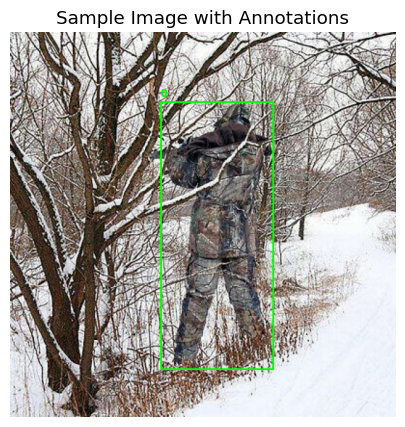

In [18]:

def plot_sample_with_annotations(image_paths, label_paths):
    img = cv2.imread(image_paths)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_filename = os.path.basename(image_paths).replace('.jpg', '.txt').replace('.png', '.txt')
    label_full_path = os.path.join(os.path.dirname(label_paths).replace('images', 'labels'), label_filename)
    with open(label_full_path, 'r') as f:
        lines = f.readlines()
        print(f"Lines read from {label_full_path}: {lines}") 
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            img_height, img_width = img.shape[:2]
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(img, str(int(class_id)), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.title('Sample Image with Annotations')
    plt.axis('off')
    plt.show()

# Plot first sample with debug
if image_paths and label_paths:
    print(f"Image: {image_paths[0]}, Intended Label: {os.path.join(os.path.dirname(image_paths[0]).replace('images', 'labels'), os.path.basename(image_paths[0]).replace('.jpg', '.txt'))}")
    plot_sample_with_annotations(image_paths[0], label_paths[0])

### Dataset Splits - Train-Test-Validation Distribution

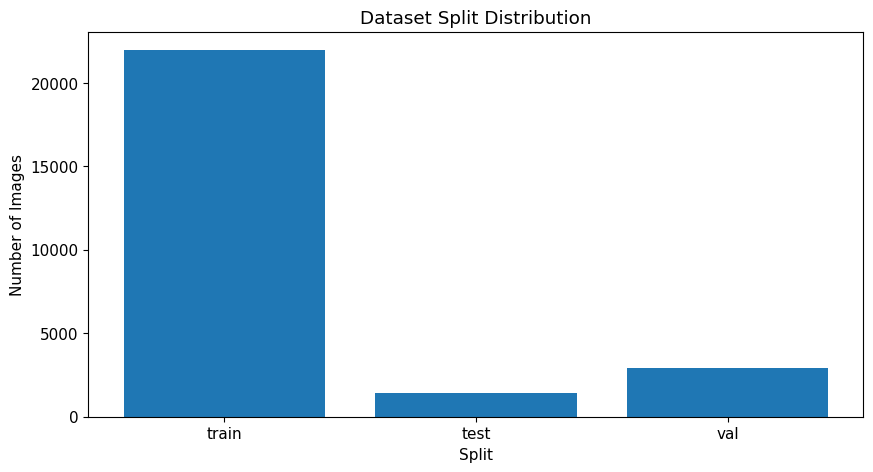

Split Distribution: {'train': 21978, 'test': 1396, 'val': 2941}


In [ ]:

def analyze_dataset_splits(base_path):
    splits = {'train': 0, 'test': 0, 'val': 0}
    for split in splits.keys():
        split_path = os.path.join(base_path, '..', split, 'images')  
        if os.path.exists(split_path):
            image_paths_split = [f for f in os.listdir(split_path) if f.endswith(('.jpg', '.png'))]
            splits[split] = len(image_paths_split)
    return splits

base_path = 'D:/Final_project/military_object_dataset/train'
split_counts = analyze_dataset_splits(train_path)

plt.figure(figsize=(10, 5))
plt.bar(split_counts.keys(), split_counts.values())
plt.title('Dataset Split Distribution')
plt.xlabel('Split')
plt.ylabel('Number of Images')
plt.show()

print("Split Distribution:", split_counts)

### Data Augmentation Analysis - Augmentation Impact

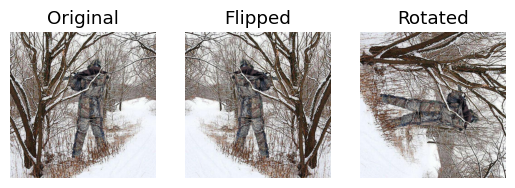

In [20]:

def apply_augmentation(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    
    # Flipped horizontally
    flipped = cv2.flip(img, 1)
    plt.subplot(1, 3, 2)
    plt.imshow(flipped)
    plt.title('Flipped')
    plt.axis('off')
    
    # Rotated 90 degrees
    rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    plt.subplot(1, 3, 3)
    plt.imshow(rotated)
    plt.title('Rotated')
    plt.axis('off')
    
    plt.show()

if image_paths:
    apply_augmentation(image_paths[0])
    

### Challenges and Insights - Class Imbalance

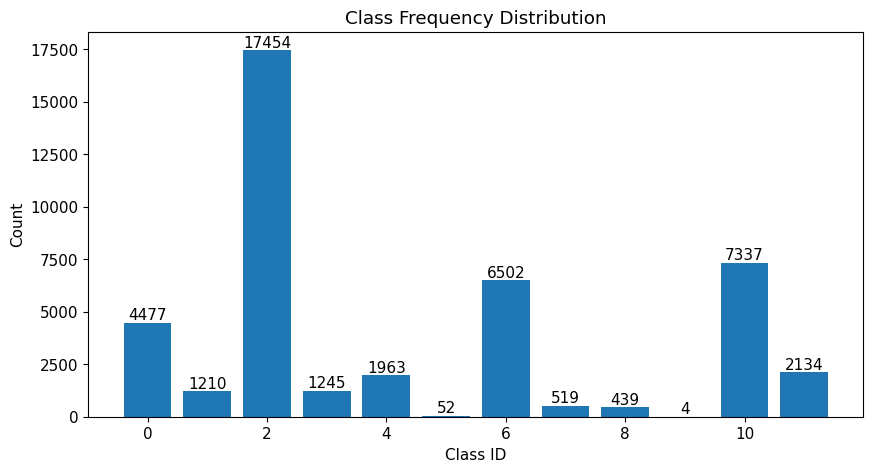

Minimum class count: 4


In [28]:

def get_class_frequencies(label_paths):
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0,9: 0,10: 0,11: 0} 
    for label_path in label_paths[:]:  
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 1:  
                    class_id = int(parts[0])
                    if class_id not in class_counts:
                        class_counts[class_id] = 0 
                        print(f"Warning: New class ID {class_id} detected in {label_path}")
                    class_counts[class_id] += 1
    return class_counts

class_freq = get_class_frequencies(label_paths)

plt.figure(figsize=(10, 5))
plt.bar(class_freq.keys(), class_freq.values())
plt.title('Class Frequency Distribution')
plt.xlabel('Class ID')
plt.ylabel('Count')
for i, v in enumerate(class_freq.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.show()

min_class_count = min(class_freq.values())
print(f"Minimum class count: {min_class_count}")


### Challenges and Insights - Annotation Quality

In [29]:

def check_annotation_quality(label_paths):
    missing_annotations = 0
    for label_path in label_paths[:100]:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            if not lines:
                missing_annotations += 1
    return missing_annotations

missing_annotations = check_annotation_quality(label_paths)
print(f"Number of label files with missing annotations: {missing_annotations}")

Number of label files with missing annotations: 15


# Image processing

### Select 1000-Image Subset

In [ ]:

subset_size = 1000
random.seed(42)  
base_path = 'D:/Final_project/military_object_dataset/train/images'
image_paths = [os.path.join(base_path, f) for f in os.listdir(base_path) if f.endswith(('.jpg', '.png'))]

# Checking that do we have enough images
if len(image_paths) < subset_size:
    print(f"Only {len(image_paths)} images found. Adjusting subset_size to {len(image_paths)}.")
    subset_size = len(image_paths)

subset_image_paths = random.sample(image_paths, subset_size)

# Creating a directory for the subset
subset_train_path = 'D:/Final_project/military_object_dataset/subset_train'
os.makedirs(os.path.join(subset_train_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(subset_train_path, 'labels'), exist_ok=True)

# Copying the images and corresponding labels
for img_path in subset_image_paths:
    img_filename = os.path.basename(img_path)
    label_filename = img_filename.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(base_path.replace('images', 'labels'), label_filename)
    if os.path.exists(label_path):
        shutil.copy(img_path, os.path.join(subset_train_path, 'images', img_filename))
        shutil.copy(label_path, os.path.join(subset_train_path, 'labels', label_filename))
    else:
        print(f"No label found for {img_path}")

print(f"Created subset with {len(os.listdir(os.path.join(subset_train_path, 'images')))} images and {len(os.listdir(os.path.join(subset_train_path, 'labels')))} labels.")

Created subset with 1000 images and 1000 labels.


### Verify Subset and Handle Missing Labels

In [ ]:

subset_images = os.listdir(os.path.join(subset_train_path, 'images'))
subset_labels = os.listdir(os.path.join(subset_train_path, 'labels'))

missing_labels = [img for img in subset_images if img.replace('.jpg', '.txt').replace('.png', '.txt') not in subset_labels]
if missing_labels:
    print(f"Missing labels for {len(missing_labels)} images: {missing_labels[:5]}")
    for img in missing_labels:
        os.remove(os.path.join(subset_train_path, 'images', img))
    print(f"Removed images without labels. Updated count: {len(os.listdir(os.path.join(subset_train_path, 'images')))}")
else:
    print("All images have corresponding labels.")

All images have corresponding labels.


### Prepare YOLOv5 Configuration (Updated)

In [21]:


yaml_source = 'D:/Final_project/military_object_dataset/military_dataset.yaml'
yaml_dest = 'data.yaml'
shutil.copy(yaml_source, yaml_dest)

with open(yaml_dest, 'r') as f:
    data = yaml.safe_load(f)
data['path'] = 'D:/Final_project/military_object_dataset/subset_train'
data['train'] = 'images'
data['val'] = 'images'  

with open(yaml_dest, 'w') as f:
    yaml.dump(data, f)

print("Updated data.yaml with subset path")

Updated data.yaml with subset path


### Data Augmentation Configuration

In [22]:

with open('data.yaml', 'r') as f:
    data = yaml.safe_load(f)


data['augmentation'] = {
    'hsv_h': 0.015,  # Hue augmentation
    'hsv_s': 0.7,    # Saturation augmentation
    'hsv_v': 0.4,    # Value (brightness) augmentation
    'degrees': 10.0, # Rotation
    'translate': 0.1,# Translation
    'scale': 0.5,    # Scaling
    'flipud': 0.5,   # Vertical flip
    'fliplr': 0.5,   # Horizontal flip
    'mosaic': 1.0,   # Mosaic augmentation
    'mixup': 0.0     # Mixup augmentation
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

print("Updated data.yaml with augmentation settings.")

Updated data.yaml with augmentation settings.


### Train YOLOv5 Model

In [ ]:

device = 0 if torch.cuda.is_available() else 'cpu'
print(f"Training on device: {device}")
sys.argv = ['train.py'] 

train.run(
    data='data.yaml',
    imgsz=640,
    batch_size=16,
    epochs=10,
    weights='yolov5s.pt',  
    project='runs/train',
    name='military_exp',
    device=device,
    cache=True
)

D:\Final_project\yolov5\utils\general.py:32: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5\data\hyps, resume_evolve=None, bucket=, cache=True, image_weights=False, device=cpu, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=military_exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, 

YOLOv5 is installed correctly.
Dataset paths verified: train=D:/Final_project/military_object_dataset/subset_train\images, val=D:/Final_project/military_object_dataset/subset_train\images
Training on device: cpu
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5


YOLOv5  v7.0-422-g2540fd4c Python-3.12.3 torch-2.7.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
Comet: run 'pip install comet_ml' to automatically track and visualize YOLOv5  runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs\train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=12

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2  

Model training completed. Check 'runs/train/military_exp' for results.


In [ ]:

best_model_path = 'runs/train/military_exp6/weights/best.pt'
save_path = 'D:/Final_project/military_model_best.pt'
shutil.copy(best_model_path, save_path)

print(f"Model saved to {save_path}")

Model saved to D:/Final_project/military_model_best.pt
